# Jupyter notebook based on ImageD11 to process scanning 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 12/10/2024

This notebook will view the results of the point-by-point process, and to save a single-valued version of the pbp map to H5, ParaView XDMF and MTEX CTF.
To get much better strains, slightly better orientations and possibly better grain shapes, you should run pbp_3_refinement
Then run 4_visualise to convert the refinement results to an accurate single-valued map with good strains.

In [1]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [2]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_file = 'si_cube_test/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5'

# which phase to index
phase_str = 'Si'

# the minimum number of peaks you want a pixel to have to be counted
min_unique = 20

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [3]:
# Parameters
PYTHONPATH = "../"
dset_file = "pbp_route/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5"
phase_str = "Si"
min_unique = 20


In [4]:
import numba
import numpy as np
import scipy.ndimage as ndi
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

from ImageD11.grain import grain
from ImageD11 import unitcell
import ImageD11.sinograms.dataset
from ImageD11.sinograms.point_by_point import PBPMap, nb_inv
from ImageD11.sinograms.tensor_map import TensorMap
from ImageD11.nbGui import nb_utils as utils

%matplotlib ipympl

In [5]:
# USER: Pass path to dataset file

ds = ImageD11.sinograms.dataset.load(dset_file)
   
sample = ds.sample
dataset = ds.dsname
rawdata_path = ds.dataroot
processed_data_root_dir = ds.analysisroot

print(ds)
print(ds.shape)

dataroot = "/home/esrf/james1997a/Code/ImageD11/test/pbp_route/raw"
analysisroot = "/home/esrf/james1997a/Code/ImageD11/test/pbp_route/processed"
sample = "Si_cube"
dset = "S3DXRD_nt_moves_dty"
shape = ( 41, 3620)
# scans 41 from 1.1 to 41.1
(41, 3620)


In [6]:
# load phases from parameter file

ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Si': <ImageD11.unitcell.unitcell at 0x145e90d1f050>}

In [7]:
# now let's select a phase to index from our parameters json

ref_ucell = ds.phases.unitcells[phase_str]

print(ref_ucell.lattice_parameters, ref_ucell.spacegroup)

[ 5.43  5.43  5.43 90.   90.   90.  ] 227


In [8]:
# load the point-by-point map

pmap = PBPMap(ds.pbpfile)

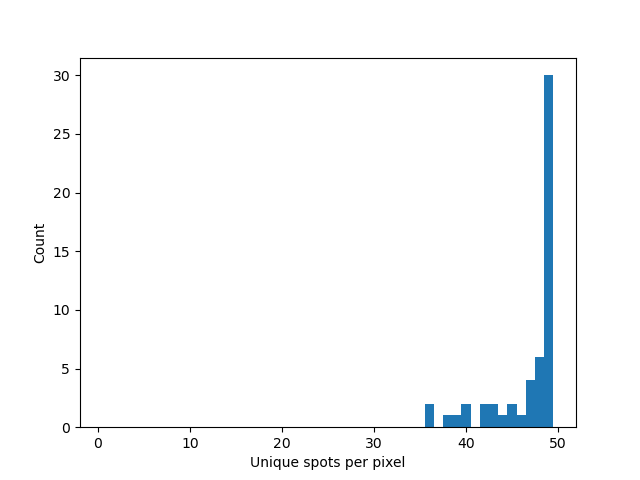

In [9]:
# plot a histogram of unique peaks per ubi

pmap.plot_nuniq_hist()

In [10]:
# choose the minimum number of peaks you want a pixel to have to be counted

pmap.choose_best(min_unique)

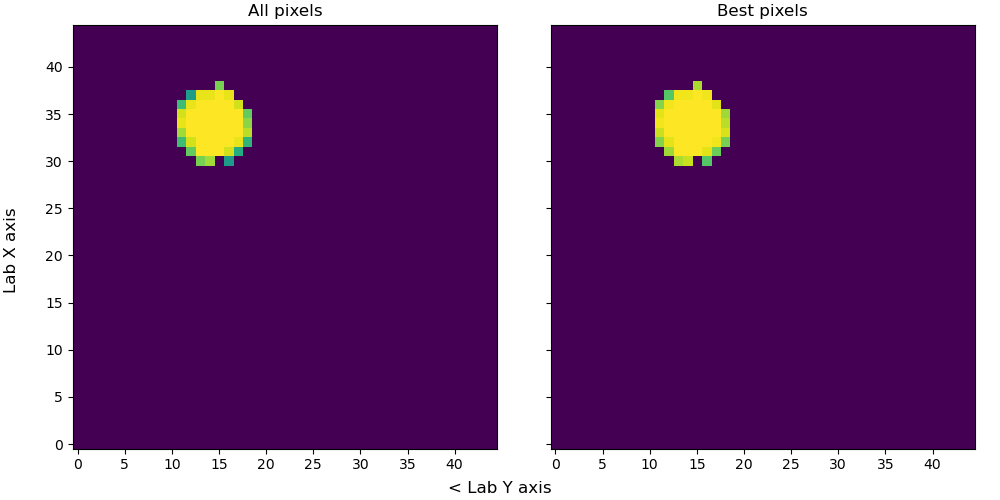

In [11]:
# let's plot the result of your choice

pmap.plot_best(min_unique)

In [12]:
# we can choose to make a TensorMap here
# which is useful for Paraview and MTEX visualisations
# if you're not interested in refining

# now make a TensorMap from it so we can plot and export

# first let's work out what phase we have
phases = {0: ref_ucell}

# let's make a phase id map from our pbpmap
phase_ids = TensorMap.recon_order_to_map_order(np.where(pmap.best_nuniq > min_unique, 0, -1))

tmap = TensorMap.from_pbpmap(pmap, steps=(1, ds.ystep, ds.ystep), phases=phases)
tmap['phase_ids'] = phase_ids

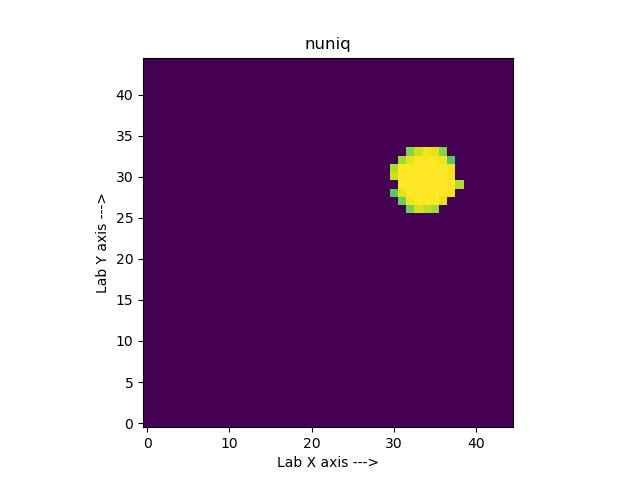

In [13]:
# plot the tensormap unique peaks

tmap.plot('nuniq')

In [14]:
# compute the IPF colours from the UBIs and phase

tmap.get_ipf_maps()

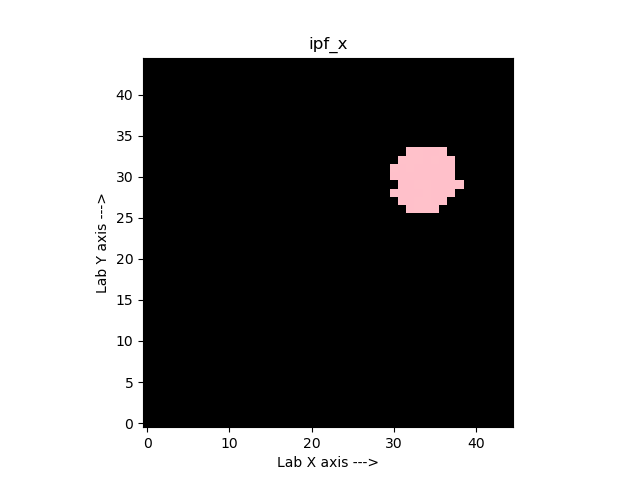

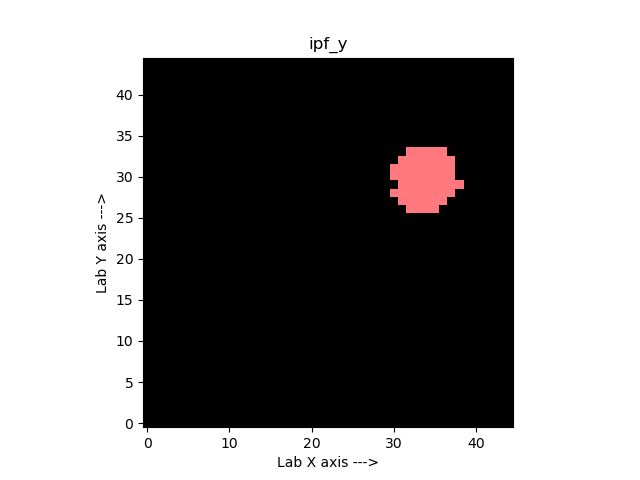

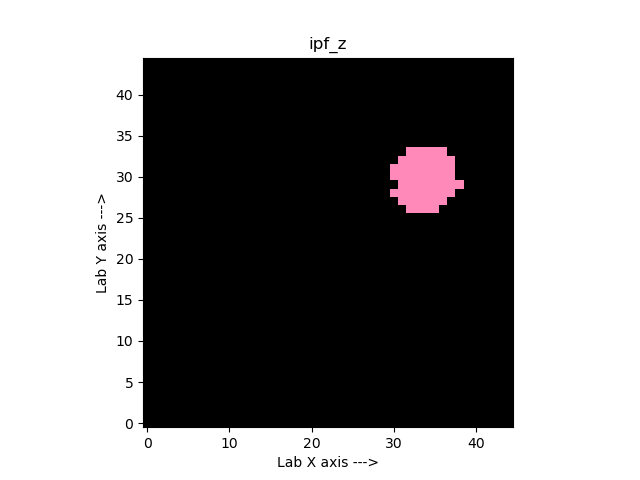

In [15]:
tmap.plot('ipf_x')
tmap.plot('ipf_y')
tmap.plot('ipf_z')

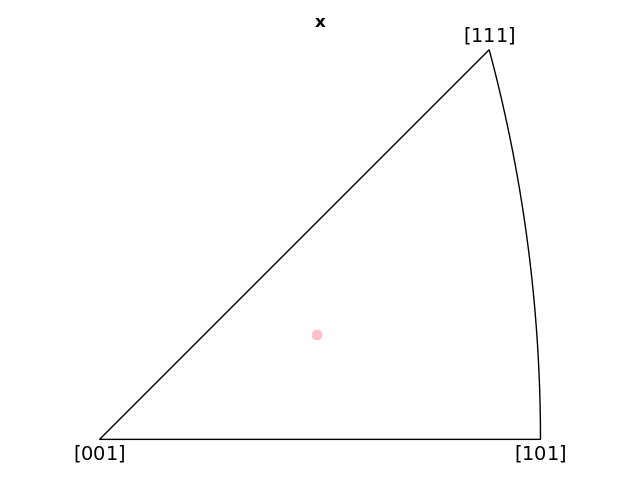

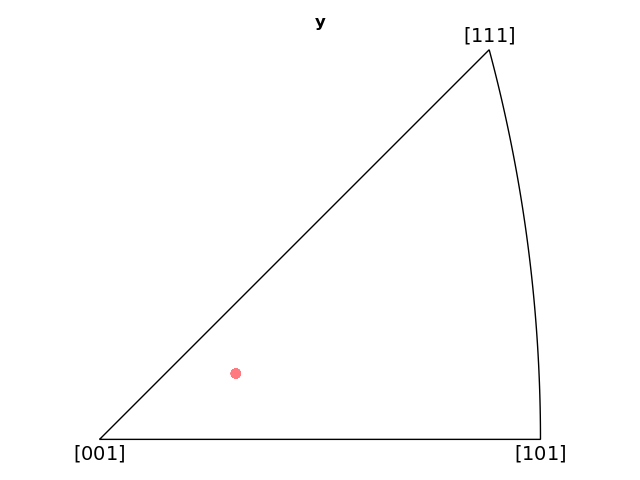

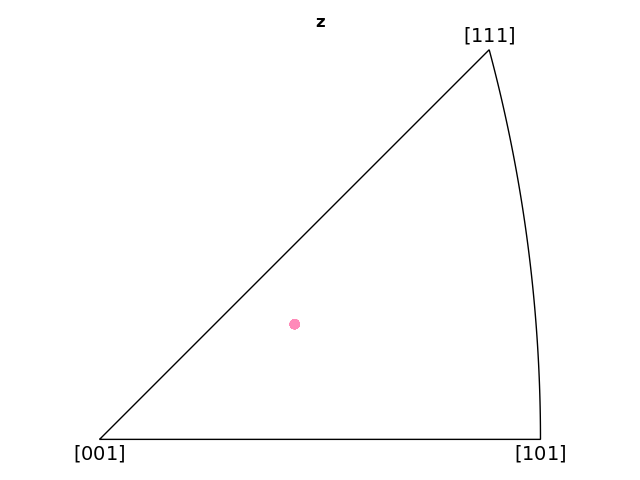

In [16]:
utils.plot_all_ipfs_from_meta_orien(tmap.get_meta_orix_orien(), tmap.phases[0])

/tmp/ipykernel_3991894/290161948.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu_r')


Calculating eps_sample from UBI


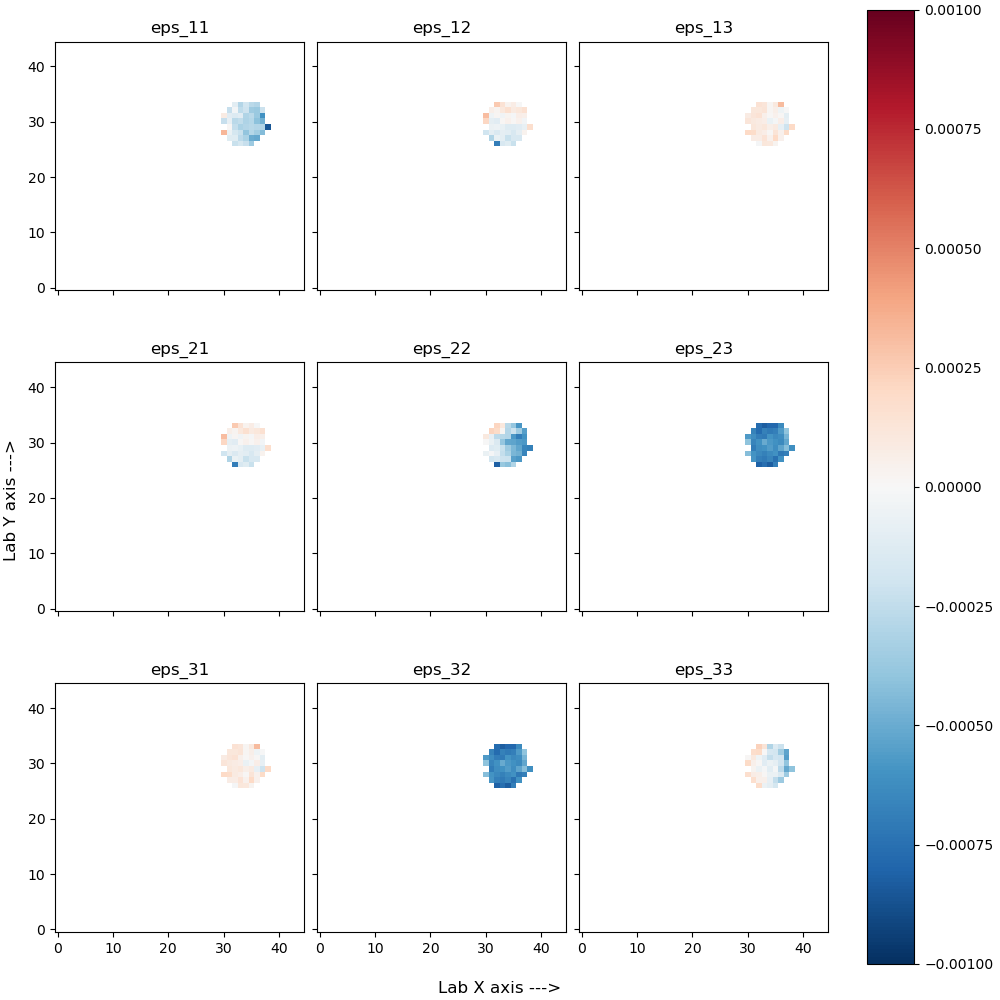

In [17]:
# plot some (probably extremely messy) strains

fig, axs = plt.subplots(3,3, sharex=True, sharey=True, layout='constrained', figsize=(10,10))

cmap = cm.get_cmap('RdBu_r')
normalizer = Normalize(-1e-3, 1e-3)
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)

for i in range(3):
    for j in range(3):
        axs[i,j].imshow(tmap.eps_sample[0, ..., i, j], origin="lower", cmap=cmap, norm=normalizer)
        axs[i,j].set_title(f'eps_{i+1}{j+1}')
fig.supxlabel('Lab X axis --->')
fig.supylabel('Lab Y axis --->')
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

In [18]:
# save the TensorMap to disk

tmap_path = os.path.join(ds.analysispath, f'{ds.sample}_{ds.dset}_tmap.h5')

tmap.to_h5(tmap_path)
tmap.to_paraview(tmap_path)

In [19]:
# you can also do an MTEX export if you like:

ctf_path = os.path.join(ds.analysispath, f'{ds.sample}_{ds.dset}_tmap.ctf')

tmap.to_ctf_mtex(ctf_path, z_index=0)

CTF exported!
In MTEX, run the command:
import_wizard('EBSD')
Click the '+', choose file /home/esrf/james1997a/Code/ImageD11/test/pbp_route/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_tmap.ctf and click 'Open'
Click 'Next >>'
Click 'Next >>' though the phases, changing if necessary (should be right though)
Choose 'apply rotation to Euler angles and spatial coordinates' with an angle of [0,0,0]
Choose the default MTEX plotting convention (X east, Y north)
Click 'Next >>' then 'script (m-file)' for the 'Import to', then 'Finish'
Click 'Run' at the top, save the import script somewhere, then it should run
Your EBSD should now be imported into MTEX. You can try to plot it with 'plot(ebsd)'


In [20]:
# We can run the below cell to do this in bulk for many samples/datasets
# by default this will do all samples in sample_list, all datasets with a prefix of dset_prefix
# you can add samples and datasets to skip in skips_dict

skips_dict = {
    "FeAu_0p5_tR_nscope": ["top_-50um", "top_-100um"]
}

dset_prefix = "top"

sample_list = ["FeAu_0p5_tR_nscope"]
    
samples_dict = utils.find_datasets_to_process(ds.dataroot, skips_dict, dset_prefix, sample_list)
    
# manual override:
# samples_dict = {"FeAu_0p5_tR_nscope": ["top_100um", "top_150um"]}
    
# now we have our samples_dict, we can process our data:

for sample, datasets in samples_dict.items():
    for dataset in datasets:
        print(f"Processing dataset {dataset} in sample {sample}")
        dset_path = os.path.join(ds.analysisroot, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")
        if not os.path.exists(dset_path):
            print(f"Missing DataSet file for {dataset} in sample {sample}, skipping")
            continue
        
        print("Importing DataSet object")
        
        ds = ImageD11.sinograms.dataset.load(dset_path)
        ds.phases = ds.get_phases_from_disk()
        ref_ucell = ds.phases.unitcells[phase_str]
        pmap = PBPMap(ds.pbpfile)
        pmap.choose_best(min_unique)
        phases = {0: ref_ucell}
        phase_ids = TensorMap.recon_order_to_map_order(np.where(pmap.best_nuniq > min_unique, 0, -1))
        tmap = TensorMap.from_pbpmap(pmap, steps=(1, ds.ystep, ds.ystep), phases=phases)
        tmap['phase_ids'] = phase_ids
        tmap.get_ipf_maps()
        tmap_path = os.path.join(ds.analysispath, f'{ds.sample}_{ds.dset}_tmap.h5')
        tmap.to_h5(tmap_path)
        tmap.to_paraview(tmap_path)
        ctf_path = os.path.join(ds.analysispath, f'{ds.sample}_{ds.dset}_tmap.ctf')
        tmap.to_ctf_mtex(ctf_path, z_index=0)

print("Done!")

Done!
